In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import itertools
import seaborn as sns
import pickle
import joblib
import os

from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.neighbors import KNeighborsRegressor
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.ensemble import RandomForestRegressor

# Functions

In [2]:
def save_model(model, model_path):
    with open(model_path, 'wb') as f:
        pickle.dump(model, f)

def load_model(model_path):
    with open(model_path, 'rb') as f:
        return pickle.load(f)

def load_dataset(folder_name):
    with open(f'../data/{folder_name}/train.pkl', 'rb') as f:
        X_train, y_train = pickle.load(f)
    with open(f'../data/{folder_name}/val.pkl', 'rb') as f:
        X_val, y_val = pickle.load(f)
    with open(f'../data/{folder_name}/test.pkl', 'rb') as f:
        X_test, y_test = pickle.load(f)
    
    scaler_y = None
    if folder_name in ['norm', 'hot_norm']:
        with open(f'../data/scaler_y.pkl', 'rb') as f:
            scaler_y = pickle.load(f)
    
    return X_train, X_val, X_test, y_train, y_val, y_test, scaler_y

def evaluate_model(model, model_path, X_train, X_val, X_test, y_train, y_val, y_test, scaler_y=None, dataset_name=''):
    performances = []
    data_splits = [(X_train, y_train, 'train'), (X_val, y_val, 'val'), (X_test, y_test, 'test')]
    
    for x, y, nsplit in data_splits:
        preds = model.predict(x)
        r2 = r2_score(y, preds)
        rmse = np.sqrt(mean_squared_error(y, preds))
        mae = mean_absolute_error(y, preds)
        
        # Update model name to include number of neighbors, weights, and metric if KNN
        model_name = model.__class__.__name__
        if model_name == 'KNeighborsRegressor':
            model_name += f" (k={model.n_neighbors}, weights={model.weights}, metric={model.metric})"
        
        performances.append({
            'model': model_name,
            'dataset': dataset_name,
            'split': nsplit,
            'rmse': rmse.round(4),
            'mae': mae.round(4),
            'r2': r2.round(4),
            'inversed': False,
            'model_path': model_path
        })
        
        if scaler_y is not None:
            preds_original = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
            y_original = scaler_y.inverse_transform(y.reshape(-1, 1)).flatten()
            
            r2_original = r2_score(y_original, preds_original)
            rmse_original = np.sqrt(mean_squared_error(y_original, preds_original))
            mae_original = mean_absolute_error(y_original, preds_original)
            
            performances.append({
                'model': model_name,
                'dataset': dataset_name,
                'split': nsplit,
                'rmse': rmse_original.round(4),
                'mae': mae_original.round(4),
                'r2': r2_original.round(4),
                'inversed': True,
                'model_path': model_path
            })
    
    return performances

# Custom grid search function
def custom_grid_search_knn(X_train, y_train, param_grid, dataset_name):
    model_dir = '../models'
    os.makedirs(model_dir, exist_ok=True)
    
    for params in param_grid:
        knn = KNeighborsRegressor(**params)
        knn.fit(X_train, y_train)
        
        model_path = os.path.join(model_dir, f'knn_{params["n_neighbors"]}_neighbors_{params["weights"]}_{params["metric"]}_{dataset_name}.pkl')
        save_model(knn, model_path)
        print(f"Trained and saved KNeighborsRegressor model with parameters {params} to {model_path}")


# Fit models

# KNN

In [5]:
# Define parameter grid for KNN
param_grid_knn = [{'n_neighbors': k, 'weights': w, 'metric': m} for k in [5, 10, 20, 30, 100] for w in ['uniform', 'distance'] for m in ['euclidean', 'manhattan']]

# Initialize a list to store all performances
all_performances = []

# List of dataset names and their corresponding folder names
dataset_names = ['hot_norm']

# Load each dataset and perform custom grid search
for dataset_name in dataset_names:
    X_train, X_val, X_test, y_train, y_val, y_test, scaler_y = load_dataset(dataset_name)
    custom_grid_search_knn(X_train, y_train, param_grid_knn, dataset_name)
    
    # Evaluate all saved models
    for params in param_grid_knn:
        model_path = os.path.join('../models', f'knn_{params["n_neighbors"]}_neighbors_{params["weights"]}_{params["metric"]}_{dataset_name}.pkl')
        knn = load_model(model_path)
        performances = evaluate_model(knn, model_path, X_train, X_val, X_test, y_train, y_val, y_test, scaler_y=scaler_y, dataset_name=dataset_name)
        all_performances.extend(performances)

# Display performances
for performance in all_performances:
    print(performance)

# Save performances to a CSV file
perf_df = pd.DataFrame(all_performances)
perf_df.to_csv('../data/knn_performances.csv', index=False)


Trained and saved KNeighborsRegressor model with parameters {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'euclidean'} to ../models/knn_5_neighbors_uniform_euclidean_hot_norm.pkl
Trained and saved KNeighborsRegressor model with parameters {'n_neighbors': 5, 'weights': 'uniform', 'metric': 'manhattan'} to ../models/knn_5_neighbors_uniform_manhattan_hot_norm.pkl
Trained and saved KNeighborsRegressor model with parameters {'n_neighbors': 5, 'weights': 'distance', 'metric': 'euclidean'} to ../models/knn_5_neighbors_distance_euclidean_hot_norm.pkl
Trained and saved KNeighborsRegressor model with parameters {'n_neighbors': 5, 'weights': 'distance', 'metric': 'manhattan'} to ../models/knn_5_neighbors_distance_manhattan_hot_norm.pkl
Trained and saved KNeighborsRegressor model with parameters {'n_neighbors': 10, 'weights': 'uniform', 'metric': 'euclidean'} to ../models/knn_10_neighbors_uniform_euclidean_hot_norm.pkl
Trained and saved KNeighborsRegressor model with parameters {'n_neighbors'

# Forest

# Clean

In [8]:
# Split the DataFrame into inversed and non-inversed
inversed_df = perf_df[perf_df['inversed'] == True]
NOT_inversed_df = perf_df[perf_df['inversed'] == False]

In [7]:
perf_df

,model,dataset,split,rmse,mae,r2,inversed,model_path,plot_name
0,"KNeighborsRegressor (k=5, weights=uniform, met...",hot_norm,train,0.0614,0.0378,0.7659,False,../models/knn_5_neighbors_uniform_euclidean_ho...,"KNeighborsRegressor (k=5, weights=uniform, met..."
1,"KNeighborsRegressor (k=5, weights=uniform, met...",hot_norm,train,89.4365,55.1123,0.7659,True,../models/knn_5_neighbors_uniform_euclidean_ho...,"KNeighborsRegressor (k=5, weights=uniform, met..."
2,"KNeighborsRegressor (k=5, weights=uniform, met...",hot_norm,val,0.0781,0.0475,0.6219,False,../models/knn_5_neighbors_uniform_euclidean_ho...,"KNeighborsRegressor (k=5, weights=uniform, met..."
3,"KNeighborsRegressor (k=5, weights=uniform, met...",hot_norm,val,113.8848,69.2649,0.6219,True,../models/knn_5_neighbors_uniform_euclidean_ho...,"KNeighborsRegressor (k=5, weights=uniform, met..."
4,"KNeighborsRegressor (k=5, weights=uniform, met...",hot_norm,test,0.0775,0.0477,0.6332,False,../models/knn_5_neighbors_uniform_euclidean_ho...,"KNeighborsRegressor (k=5, weights=uniform, met..."
...,...,...,...,...,...,...,...,...,...
115,"KNeighborsRegressor (k=100, weights=distance, ...",hot_norm,train,0.0000,0.0000,1.0000,True,../models/knn_100_neighbors_distance_manhattan...,"KNeighborsRegressor (k=100, weights=distance, ..."
116,"KNeighborsRegressor (k=100, weights=distance, ...",hot_norm,val,0.0762,0.0452,0.6401,False,../models/knn_100_neighbors_distance_manhattan...,"KNeighborsRegressor (k=100, weights=distance, ..."
117,"KNeighborsRegressor (k=100, weights=distance, ...",hot_norm,val,111.1146,65.8211,0.6401,True,../models/knn_100_neighbors_distance_manhattan...,"KNeighborsRegressor (k=100, weights=distance, ..."
118,"KNeighborsRegressor (k=100, weights=distance, ...",hot_norm,test,0.0752,0.0455,0.6551,False,../models/knn_100_neighbors_distance_manhattan...,"KNeighborsRegressor (k=100, weights=distance, ..."


# Plot

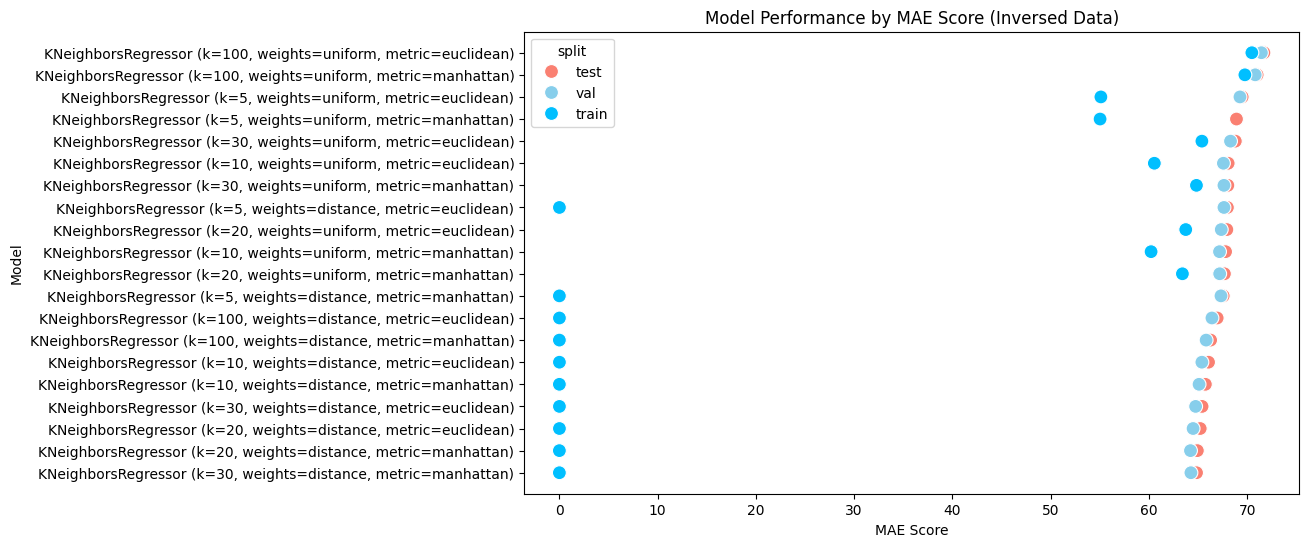

In [10]:
# Plot for Filtered Data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=inversed_df.sort_values(by='mae', ascending=False), 
                y='model', 
                x='mae', 
                palette={'train': 'deepskyblue', 'val': 'skyblue', 'test': 'salmon'},# Custom color palette
                marker='o',   # Circle markers
                s=100,        # Size of the markers
                hue='split'   # Color by split
                )  

# Adding plot title
plt.title('Model Performance by MAE Score (Inversed Data)')

# Adding x and y axis labels
plt.xlabel('MAE Score')
plt.ylabel('Model')

# Save plot
#plt.savefig('../plots/filtered_models_MAE.png')
# Display the plot
plt.show()


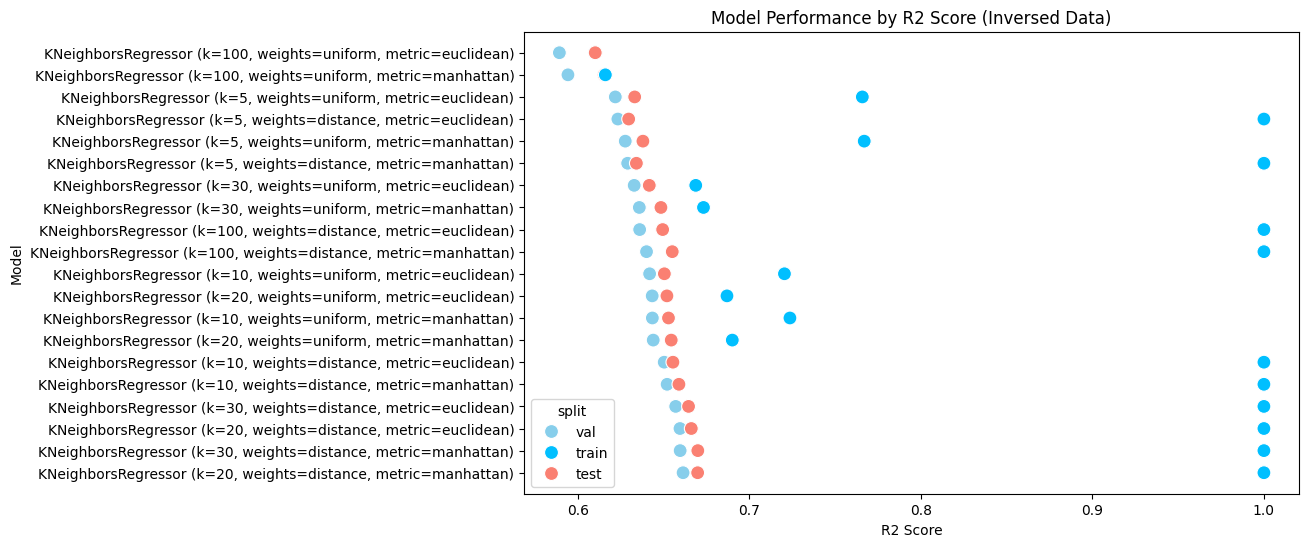

In [13]:
# Plot for Filtered Data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=inversed_df.sort_values(by='r2', ascending=True), 
                y='model', 
                x='r2', 
                palette={'train': 'deepskyblue', 'val': 'skyblue', 'test': 'salmon'},# Custom color palette
                marker='o',   # Circle markers
                s=100,        # Size of the markers
                hue='split'   # Color by split
                )  

# Adding plot title
plt.title('Model Performance by R2 Score (Inversed Data)')

# Adding x and y axis labels
plt.xlabel('R2 Score')
plt.ylabel('Model')

# Save plot
#plt.savefig('../plots/filtered_models_R2.png')
# Display the plot
plt.show()


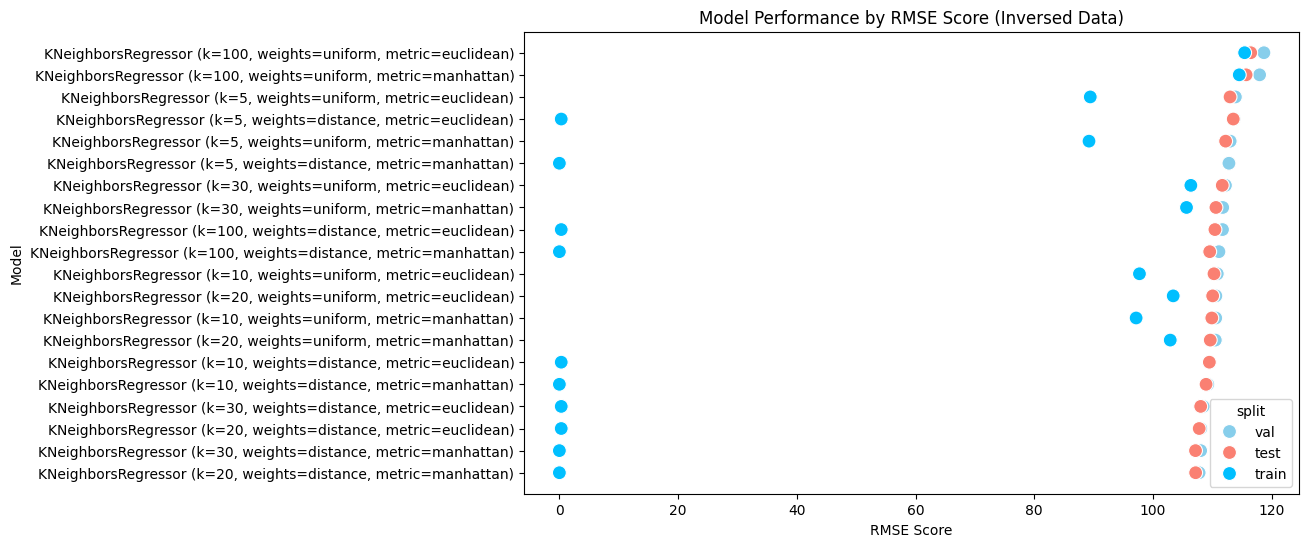

In [15]:
# Plot for Filtered Data
plt.figure(figsize=(10, 6))
sns.scatterplot(data=inversed_df.sort_values(by='rmse', ascending=False), 
                y='model', 
                x='rmse', 
                palette={'train': 'deepskyblue', 'val': 'skyblue', 'test': 'salmon'},# Custom color palette
                marker='o',   # Circle markers
                s=100,        # Size of the markers
                hue='split'   # Color by split
                )  

# Adding plot title
plt.title('Model Performance by RMSE Score (Inversed Data)')

# Adding x and y axis labels
plt.xlabel('RMSE Score')
plt.ylabel('Model')

# Save plot
#plt.savefig('../plots/filtered_models_R2.png')
# Display the plot
plt.show()


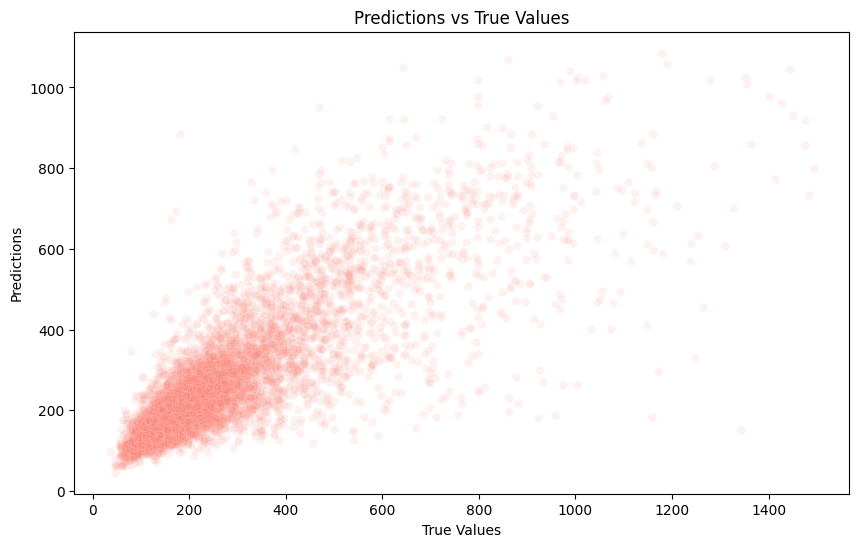

In [17]:
# Load knn model 20, distance, manhattan, hot_norm
knn = load_model('../models/knn_20_neighbors_distance_manhattan_hot_norm.pkl')
# Make predictions on test set
X_train, X_val, X_test, y_train, y_val, y_test, scaler_y = load_dataset('hot_norm')
preds = knn.predict(X_test)
# Inverse transform the predictions
preds_original = scaler_y.inverse_transform(preds.reshape(-1, 1)).flatten()
y_original = scaler_y.inverse_transform(y_test.reshape(-1, 1)).flatten()

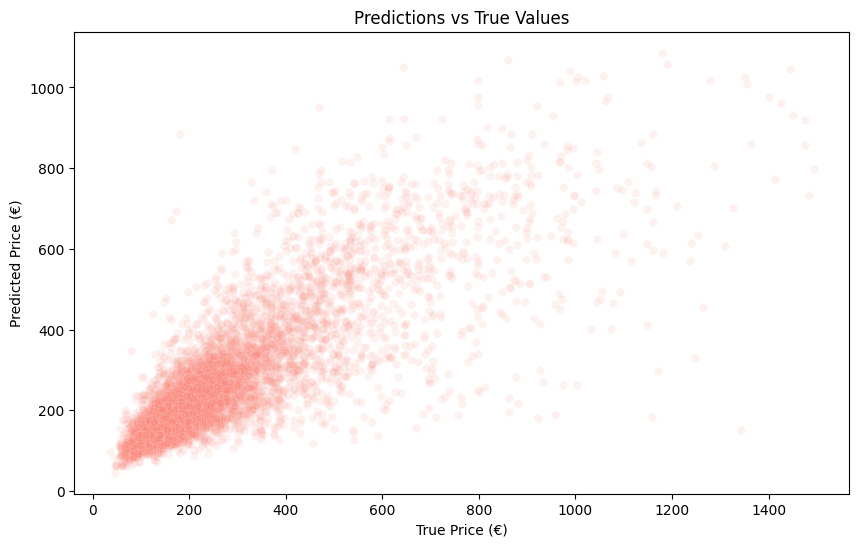

In [21]:
# Plot the predictions
plt.figure(figsize=(10, 6))
sns.scatterplot(x=y_original, y=preds_original, color='salmon', alpha=0.1)
plt.xlabel('True Price (€)')
plt.ylabel('Predicted Price (€)')
plt.title('Predictions vs True Values')
plt.show()

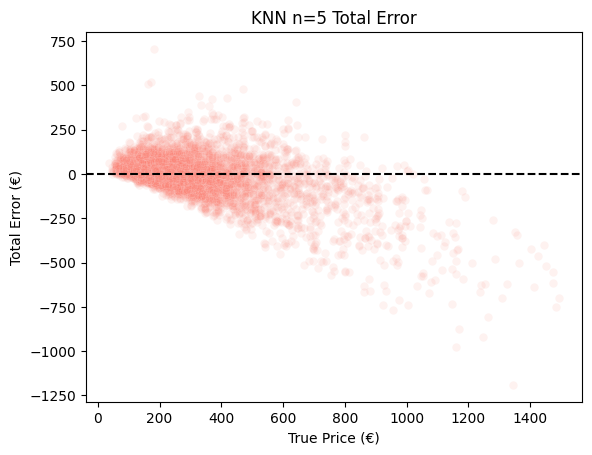

In [20]:
# Calculation of total error
total_error = preds_original - y_original

# Create scatter plot of predictions vs true values
sns.scatterplot(x=y_original, y=total_error, color='salmon', alpha=0.1)

# Add a horizontal line at y=0
plt.axhline(0, color='black', linestyle='--')

# Set the title and labels of the plot
plt.title('KNN n=5 Total Error')
plt.xlabel('True Price (€)')
plt.ylabel('Total Error (€)')

# Show the plot
plt.show()